In [1]:
#PLOTS FOR THESIS 
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")
import os
import pickle
%matplotlib inline
import copy
import datetime
fig = plt.figure(figsize=(20,5))
import warnings
warnings.filterwarnings("ignore")


def preprocess1(train_dir, delete_index_dir, notfound_index_dir):
    
    #1. load funda_train.csv
    #2. change data types
    #3. delete useless columns
    #4. delete data amount = 0 and refund data
    
    #upload needed dataset 
    data = pd.read_csv(train_dir)
    delete = delete_index_dir
    notfound = notfound_index_dir
    print('data loaded')
    
    
    #delete useless columns
    data.drop(['card_id', 'card_company', 'transacted_time', 'installment_term', 'region', 'type_of_business'], axis=1, inplace=True)
    
    #change data types 
    data['store_id'] = data['store_id'].astype('str')   
    data['transacted_date'] = pd.to_datetime(data['transacted_date'])

    print('data changed types and deleted columns ')
    
    
    #delete 0 amount value
    data = data[data['amount']!=0]
    print('deleted data with amount of zero')
    
    #delete refunded values from dataset 
        
    with open(delete, 'rb') as f: 
        delete = pickle.load(f)
        
    with open(notfound, 'rb') as f: 
        notfound = pickle.load(f)
    
    data.drop(index=delete, inplace = True )
    data.drop(index=notfound, inplace = True)
    
    print('deleted refunded values')
    
    data = data.loc[data['store_id'] != '795']
    print('delete store id 795 since it only has 2 obs:: we will predict it as 0 in the test')


    print("END PREPROCESS 1")
    
    return data  #(6410395, 3)

def monthly_sum(data1):
    data = copy.deepcopy(data1)
    
    # make month and year column 
    data['year'] = data['transacted_date'].dt.year
    data['month'] = data['transacted_date'].dt.month

    #sum up amount according to ID 
    data['ID'] = data['store_id'].astype(str)+ '-' + data['year'].astype(str) +'-' + data['month'].astype(str)        
    
    data["amount_sum"] = data.groupby('ID')["amount"].transform(sum)
    print('summed up amount')

    #delete duplicates according to ID 
    data.drop_duplicates(['ID'], keep='first', inplace =True) #only save first row 
    print('deleted duplicates in dataset')
    
    #delete amount since we will only use amount_sum for daily analysis 
    data.drop(['amount', 'year', 'ID'], axis=1, inplace=True)
    
    
    #rename amount_sum to amount 
    data.rename(columns = {'amount_sum' : 'amount'}, inplace = True)
    data.reset_index(inplace = True, drop = True)
    
    print("END MONTHLY SUM")
    
    return data # 60149 rows × 4 columns


def full_date(data):
    store_list = data['store_id'].unique()
    filled_data = pd.DataFrame()
    
    start = datetime.datetime.strptime('2016-06-01', '%Y-%m-%d')
    end = datetime.datetime.strptime('2019-02-01', '%Y-%m-%d')    
    
    for sid in store_list:
        subdata = data[data['store_id'] == sid]
        subdata['transacted_date'] = pd.DatetimeIndex(subdata['transacted_date'])
        subdata.set_index('transacted_date', inplace = True)
        
        #resampling into the start date of the month('MS')
        filled_subdata = subdata.resample('MS')
        
        #filled with Nan
        filled_subdata = filled_subdata.first()
        
        #fill the other columns
        filled_subdata.reset_index(inplace = True)
        filled_subdata['store_id'] = sid        
        
        start_subdata = pd.DataFrame(columns = ['store_id', 'transacted_date', 'month', 'amount'])
        end_subdata = pd.DataFrame(columns = ['store_id', 'transacted_date', 'month', 'amount'])
        
        # if it starts with later than 2016-6, make a new dataset for the empty dates
        if filled_subdata.loc[:, 'transacted_date'].min() > start:
            start_subdata['transacted_date'] = pd.date_range(start, filled_subdata.loc[:,'transacted_date'].min(), freq = 'MS')
            start_subdata['month'] = start_subdata['transacted_date'].dt.month
            start_subdata['amount'] = np.nan
            start_subdata['store_id'] = sid
            start_subdata = start_subdata[:-1]
                
            
        # if it ends with ealier than 2019-02, make a new dataset for the empty dates
        if filled_subdata.loc[:, 'transacted_date'].max() < end: 
            end_subdata['transacted_date'] = pd.date_range(filled_subdata.loc[:,'transacted_date'].max(), end, freq = 'MS')
            end_subdata['month'] = end_subdata['transacted_date'].dt.month
            end_subdata['amount'] = np.nan
            end_subdata['store_id'] = sid
            end_subdata = end_subdata[1:]
            
        new_filled_subdata = pd.concat([start_subdata, filled_subdata, end_subdata])
        new_filled_subdata.reset_index(inplace = True, drop = True)
           
        filled_data = pd.concat([filled_data, new_filled_subdata])
        filled_data.reset_index(inplace = True, drop = True)  
        
#         print(sid, end = '  ')
    
    print("END FULL DATE")

    return filled_data





#####################################################################################################################################
##########################DATA INTERPOLATION 


def mean_fill(data):
    
    print('fill amount with each stores mean')
    for i in data['store_id'].value_counts().index:
        k = data.loc[data['store_id'] == i, 'amount'].isnull().sum()
        
        if k > 0 :
            mean =data.loc[data['store_id'] == i,'amount'].mean()
#             print(mean)
            data.loc[(data['store_id'] == i) & (data['amount'].isnull()) , 'amount'] = mean            
    
    return data 


def median_fill(data):
    
    print('fill amount with each stores median')
    for i in data['store_id'].value_counts().index:
        k = data.loc[data['store_id'] == i, 'amount'].isnull().sum()
        
        if k > 0 :
            med =data.loc[data['store_id'] == i,'amount'].median()
#             print(mean)
            data.loc[(data['store_id'] == i) & (data['amount'].isnull()) , 'amount'] = med

            
    
    return data 







###############################################################################################################################################

def add_past_amount(data, test_dir, date_list):
    test = pd.read_csv(test_dir)

    # add column to make easy to recognize trainset and testset
    test['category'] = 'test'
    data['category'] = 'train'
    print("ADD CATEGORY")
    
    test = test[['store_id', 'transacted_date', 'amount', 'category']]
    test['transacted_date'] = pd.to_datetime(test['transacted_date'])
    test['store_id'] = test['store_id'].astype('str')
    print("COMPLETE CHANGING TEST")
    
    # concat the train and test
    com_data = pd.concat([data, test])
    print("CONCAT THE DATA AND TEST")
    
    
    print('START ADDING TIME SHIFT TO THE DATASET')
    sid_list = com_data['store_id'].unique()
    
    # shifting MS : using a start date of the month
    new = pd.DataFrame()
    for sid in sid_list:
        subdata = com_data[com_data['store_id'] == sid]
        
        
        #firstly, make the transacted_date as gyun-ill
        datelist = subdata['transacted_date']
        new_datelist = datelist.apply(lambda dt: dt.replace(day=1))
        subdata['transacted_date'] = new_datelist
        
        subdata.set_index('transacted_date', inplace = True) 
        
        for d in date_list:
            col_name = 'm-' + str(d)
            subdata[col_name] = subdata['amount'].shift(d, freq='MS')
        
        subdata.reset_index(inplace = True)
        new = pd.concat([new, subdata])
        new.reset_index(inplace = True, drop = True)
#         print(sid, end = '   ')
    
    print("END ADD PAST AMOUNT")
    
    
    return new

    


    
def rename_columns(new,k):
    print('clean columns ')
    
    
    new['transacted_date'] = pd.DatetimeIndex(new['transacted_date'])
    new['year'] = new['transacted_date'].dt.year
    new['month'] = new['transacted_date'].dt.month
    new['date'] = new['transacted_date'].apply(lambda x: x.strftime('%Y-%m')) 
    
    
    del new['transacted_date']
    

    print('rename columns')
    new.rename(columns = {'M-6' : 'six_month','M-12' : 'twelve_month'}, inplace = True)
  
    if k == 12:
        new.rename(columns = {'M-3': 'three_month'}, inplace = True)   
        
    else:
        new.rename(columns = {'M-18': 'eighteen_month'}, inplace = True)
        
    
    return new
    



def delete_past(new,n):
    print('delete train values that are lost')
     #2016-6,7,8,9,10,11,12 //// 2017-1,2,3,4,5 delete since we don't have enough
        
    #for data3 
    if n == 12:
        k= new.loc[(new.category =='train') & (new.year == 2016) & (new.month.isin([6,7,8,9,10,11,12]))].index
        l = new.loc[(new.category =='train') & (new.year == 2017) & (new.month.isin([1,2,3,4,5]))].index
    
    
    if n == 18: #16-6 ~17-11 까지 삭제해야 18개월전 삭제 가능 (2017/12 월부터가 NAN 없이 시작 )
        k= new.loc[(new.category =='train') & (new.year == 2016) & (new.month.isin([6,7,8,9,10,11,12]))].index
        l = new.loc[(new.category =='train') & (new.year == 2017) & (new.month.isin([1,2,3,4,5,6,7,8,9,10,11]))].index
    
    
    new.drop(index=k, inplace=True)
    new.drop(index=l, inplace=True)
    
    
    return new




def train_test_split(new):
    print('train, test validation')
    
    val = (new.category =='train') & new.month.isin([3,4,5])
    
    new.loc[(val), 'category'] = 'val'
    #시계열로 예측할 것 아니기 때문에 : rolling window 기법의 train test split이 불필요하다. 동일한 store 개수로 train test split 진행 
        #validation set :: test 이랑 같은 날짜로서 사용한다  

    return new 
    

    
    

def mainfunc():
    data = preprocess1('/Users/janechoi/Desktop/연구학점/credit card/data/org data/funda_train.csv', 
                       '/Users/janechoi/Desktop/연구학점/credit card/data/delete_index2.txt', 
                       '/Users/janechoi/Desktop/연구학점/credit card/data/notfound_index2.txt')
    
    # print(data.shape) # 6410395 rows × 3 columns
    
    data1 = monthly_sum(data)
    # print(data1.shape) # 60149 rows × 4 columns

    data2 = full_date(data1) 
    # print(data2.shape) # 64911 rows × 4 columns
    
    
    ######### FILL NAN VALUES :: CHOOSE ONLY ONE #####################
#     data2 = mean_fill(data2)
#     data2 = median_fill(data2)
    
    ##################################################################
    
    #seperate on both dataset 
    
    data3 = add_past_amount(data2,'/Users/janechoi/Desktop/연구학점/credit card/data/org data/funda_train.csv', [3, 6, 12])
    data3 = rename_columns(data3,12)
    data3 = data3[['store_id', 'year','month','three_month', 'six_month','twelve_month', 'amount', 'category']]
    data3 = delete_past(data3,12)   
    data3 = train_test_split(data3)
    
    
#     data4 = add_past_amount(data2, '/Users/janechoi/Desktop/연구학점/credit card/data/test.csv', [6, 12, 18])
#     data4 = rename_columns(data4,18)
#     data4 = data4[['store_id', 'year','month','six_month','twelve_month', 'eighteen_month', 'amount', 'category']]
#     data4 = delete_past(data4,18)
#     data4 = train_test_split(data4)

    
    # print(data3.shape) # 70812 rows × 8 columns
    
    return data, data1, data2, data3

org, data1, data2, final1 = mainfunc()




# final1.to_csv('train_1.csv', index=False)
# final2.to_csv('train_2.csv', index=False)

data loaded
data changed types and deleted columns 
deleted data with amount of zero
deleted refunded values
delete store id 795 since it only has 2 obs:: we will predict it as 0 in the test
END PREPROCESS 1
summed up amount


KeyboardInterrupt: 

<Figure size 1440x360 with 0 Axes>

In [ ]:
final1.isnull().sum()

>BEFORE preprocessing 

In [ ]:
#line plot for particular store id ((830, 619,271))

# data= org.loc[org['store_id'] =='830'] #1310 :: unique date 686
data= org.loc[org['store_id'] =='619'] #806  :: unique date 290 has data until 18-11-21 
# data= org.loc[org['store_id'] =='271'] #6043 :: unique date 449 
# len(data['transacted_date'].unique())
data.tail(20) #


sns.set_palette("colorblind")
sns.set_style("whitegrid")


data= org.loc[org['store_id'] =='830']
sns_plot= sns.lineplot(x='transacted_date' , y='amount', data= data)
plt.title('Store Id 830 Amount Line Graph')
plt.xticks(rotation=90)
sns_plot.figure.savefig("output830.png")



data= org.loc[org['store_id'] =='271']
sns_plot= sns.lineplot(x='transacted_date' , y='amount', data= data)
plt.title('Store Id 271 Amount Line Graph')
plt.xticks(rotation=90)
sns_plot.figure.savefig("output271.png")


data= org.loc[org['store_id'] =='619']
sns_plot= sns.lineplot(x='transacted_date' , y='amount', data= data)
plt.title('Store Id 619 Amount Line Graph')
plt.xticks(rotation=90)
sns_plot.figure.savefig("output619.png")



In [ ]:
#count plot for total count for each store (top 10, last 10 )
ax1= sns.countplot(x="store_id", data=org, order = org['store_id'].value_counts()[:10].index)

for p, label in zip(ax1.patches, org['store_id'].value_counts()[:10].index):
    count = org['store_id'].value_counts()[label]
    ax1.annotate(count, (p.get_x()+0.15, p.get_height()+0.15))
    
plt.xticks(rotation=90)
plt.title('Store ID Count MOST 10 values')
plt.show()

ax1.figure.savefig("most.png")


# ax2= sns.countplot(x="store_id", data=org, order = org['store_id'].value_counts()[-10:].index)

# for p, label in zip(ax2.patches, org['store_id'].value_counts()[-10:].index):
#     count = org['store_id'].value_counts()[label]
#     ax2.annotate(count, (p.get_x()+0.15, p.get_height()+0.15))
    
# plt.xticks(rotation=30)
# plt.title('Store ID Count LEAST 10 values')
# plt.show()
# ax2.figure.savefig("least.png")



plt.figure(figsize = (150,40))
ax = sns.countplot('store_id', data = org, order = org['store_id'].value_counts().index)
plt.title("Count Plot for Appearance of Store ID", fontsize= 100)

plt.xlabel('STORE',fontsize=80)
plt.ylabel('COUNT', fontsize=80)


# plt.xticks(fontsize=60)
plt.yticks(fontsize=60)


plt.show()
ax.figure.savefig("total.png")

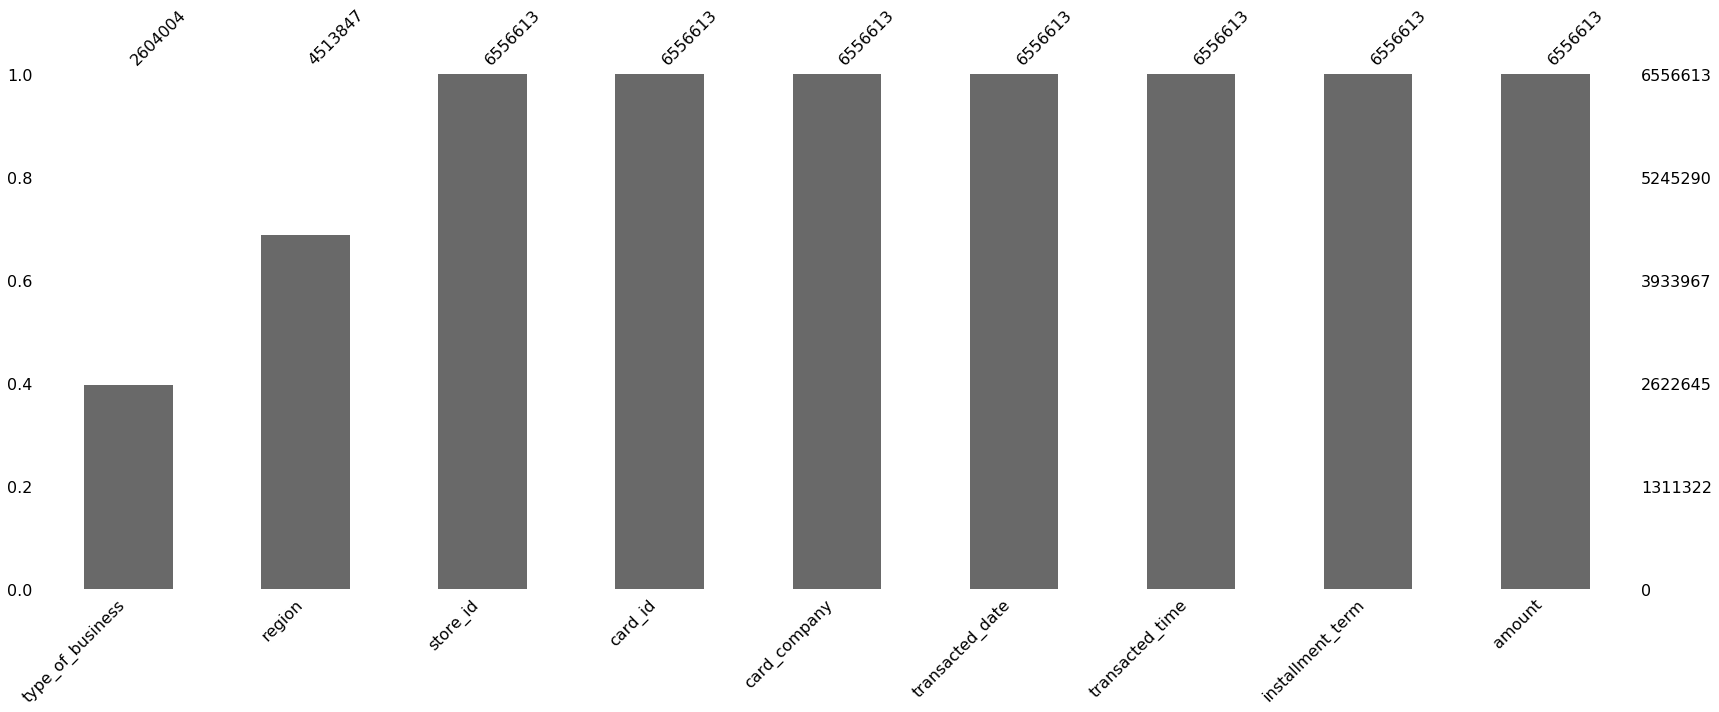

In [6]:
import pandas as pd 
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_palette("colorblind")
import os
import pickle
%matplotlib inline
import copy
import datetime
fig = plt.figure(figsize=(20,5))
import warnings
warnings.filterwarnings("ignore")
#NAN PLOTS 

org1 = pd.read_csv('/Users/janechoi/Desktop/연구학점/credit card/data/org data/funda_train.csv')
# sns_plot = sns.heatmap(org1.isnull(),cbar=False)
# plt.title('MISSING VALUES')
# final1.isnull().sum()
# sns.heatmap(final2.isnull(),cbar=False)
# final2.isnull().sum()
# sns_plot.figure.savefig("missingheatmap.png")




import missingno as msno
sns_plot2= msno.bar(org1, sort="ascending")

plt.tight_layout()


In [5]:
sns_plot2.figure.savefig("missingno.png")
print(os.getcwd())

/Users/janechoi/Desktop/연구학점/credit card/paper/github /preprocess
